# Build a Recommender System for Books
This notebook demonstrates the use of many actions within the Recommender System (recommend)
action set for SAS Cloud Analytic Services (CAS).

This example uses explicit ratings. The data set is the Book-Crossing data set<sup>[1](#data_attribution)</sup>. The data preparation excludes the implicit ratings and also excludes ratings that do not match an ISBN in the books data set.

You must have access to a SAS Viya 3.3 release of CAS. To connect to CAS from Python, you must install the SAS Scripting Wrapper for Analytics Transfer (SWAT).
* For information about SWAT, including installation, see [Python-SWAT](https://sassoftware.github.io/python-swat/).
* For information about the CAS actions used in this example, see [Recommender System Action Set: Details](http://documentation.sas.com?cdcId=pgmsascdc&cdcVersion=9.4_3.3&docsetId=casanpg&docsetTarget=n05bxq1zhsoxzun1padoh6m829y0.htm) in the *SAS Visual Analytics 8.2: Programming Guide*.

Copyright SAS Institute, Inc.

----
## Notebook contents
1. [Initial setup](#initial_setup)<br/>Import packages, including the SAS Wrapper for Analytic Transfer (SWAT) and open source libraries &cir; Connect to CAS and start a session &cir; Import the books file  &cir; Import the ratings file &cir; Upload the data frames to the server
   
2. [Simple exploration](#simple_explore)<br/>Calculate the sparsity &cir; View the ratings distribution
   
3. [Build the recommender system](#build_recommender)<br/>Partition the ratings table &cir;  Calculate average ratings by item and user &cir; Explore the item ratings and user ratings

4. [Build a matrix factorization model](#build_matrixfactorization)<br/>Sample the data for a hold-out group &cir; Build the model using ALS &cir; Make recommendations for one user

5. [Build a KNN model](#build_knn)<br/>Calculate similarity between users &cir; View rating history for similar users &cir; Recommend 10 books for one user

6. [Combine search with recommendations](#build_searchindex)<br/>Build a search index &cir;  Create a simple filter table &cir; Make recommendations from the filter table

## Initial Setup

### Import Packages: SAS Wrapper for Analytic Transfer (SWAT) and Open Source Libraries<a name="initial_setup"/>

In [1]:
import html
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import swat
from IPython.core.display import display, HTML, Markdown
from io import StringIO

%matplotlib inline

### Connect to CAS and start a session<a name="initial_connect"/>

In [2]:
s = swat.CAS("host.example.com", 5570);
s.loadactionset("dataPreprocess")
s.loadactionset("fedSql")
s.loadactionset("recommend")

data_dir = '/path/to/data/'
ratings_file = data_dir + 'BX-Book-Ratings.csv'
books_file   = data_dir + 'BX-Books.csv'

NOTE: Added action set 'dataPreprocess'.
NOTE: Added action set 'fedSql'.
NOTE: Added action set 'recommend'.


### Import the books file<a name="initial_books"/>
This file include HTML entities such as &amp;amp; that interfere with parsing.  Keep the
books with 10 characters for the ISBN.

In [3]:
with open(books_file, 'r', encoding='iso-8859-1') as f:
    content = html.unescape(f.read())

books_df = pd.read_csv(StringIO(content),
                       header=0, 
                       error_bad_lines=False,
                       sep=';', encoding='iso-8859-1',
                       names=['ISBN', 'Title', 'Author', 'Year_Of_Publication', 'Publisher'],
                       usecols=['ISBN', 'Title', 'Author', 'Year_Of_Publication', 'Publisher'],
                       dtype={'Year_Of_Publication': str})

books_df = books_df[books_df.ISBN.str.len() == 10]

In [4]:
books_df.head()

,ISBN,Title,Author,Year_Of_Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton & Company


### Import the ratings file <a name="initial_ratings"/>
The regex is used to skip invalid lines and to skip ratings with a 0. This example
uses explicit ratings only.

In [5]:
pattern = re.compile('"\d+";"[0-9X]{10}";"[1-9][0]?"')
buffer = StringIO()

with open(ratings_file, 'r', encoding='iso-8859-1') as f:
    for line in f:
        if pattern.match(line):
            buffer.write(line)
            
buffer.seek(0)            
ratings_df = pd.read_csv(buffer,
                         skiprows=0,
                         sep=';',
                         names=['User_ID', 'ISBN', 'Rating'],
                         dtype={'User_ID': str, 'ISBN': str, 'Rating': int})
buffer.close()

ratings_df.drop_duplicates(inplace=True)
ratings_df.head()

,User_ID,ISBN,Rating
0,276726,0155061224,5
1,276729,052165615X,3
2,276729,0521795028,6
3,276736,3257224281,8
4,276737,0600570967,6


### Finally, upload the data frames to the server <a name="initial_upload"/>
Because the ISBNs that are used from the data set are all 10 characters long, it is more
efficient to use a fixed-width size for them. The author and title strings vary greatly, so
VARCHAR is a better choice for those two columns.

In [6]:
ratings = s.upload_frame(ratings_df,
                         casout=s.CASTable('ratings', 
                                           replace=True,
                                           indexVars=['isbn']),
                         importoptions=dict(filetype="csv", 
                                            vars=[
                                                dict(name="User_ID", type="double"),
                                                dict(name="ISBN", type="CHAR", length=10),
                                                dict(name="Rating", type="double")
                                            ]))

books = s.upload_frame(books_df, 
                       casout=s.CASTable('books', replace=True), 
                       importoptions=dict(filetype="csv", 
                                          vars=[dict(name="ISBN", type="CHAR", length=10)]))

display(Markdown('### Books'))
display(books.table.columninfo())

display(Markdown('### Ratings'))
display(ratings.table.columninfo())

NOTE: Cloud Analytic Services made the uploaded file available as table RATINGS in caslib CASUSERHDFS(mimcki).
NOTE: The table RATINGS has been created in caslib CASUSERHDFS(mimcki) from binary data uploaded to Cloud Analytic Services.
NOTE: Cloud Analytic Services made the uploaded file available as table BOOKS in caslib CASUSERHDFS(mimcki).
NOTE: The table BOOKS has been created in caslib CASUSERHDFS(mimcki) from binary data uploaded to Cloud Analytic Services.


### Books

,Column,ID,Type,RawLength,FormattedLength,NFL,NFD
0,ISBN,1,char,10,10,0,0
1,Title,2,varchar,303,303,0,0
2,Author,3,varchar,143,143,0,0
3,Year_Of_Publication,4,double,8,12,0,0
4,Publisher,5,varchar,151,151,0,0


### Ratings

,Column,ID,Indexed,Type,RawLength,FormattedLength,NFL,NFD
0,User_ID,1,N,double,8,12,0,0
1,ISBN,2,Y,char,10,10,0,0
2,Rating,3,N,double,8,12,0,0


Discard any ratings that do not have a corresponding ISBN in the books table.

In [7]:
original_row_count = len(ratings)

s.dataStep.runCode(code='''
  data ratings;
    merge ratings(in=ratings) books(in=books keep=isbn);
    by isbn;
    if books and ratings then output;
  run;
''')

final_row_count = len(ratings)

df = pd.DataFrame([[original_row_count], [final_row_count]], 
                  columns=['Ratings Count'],
                  index=['Original', 'Final'])
df

,Ratings Count
Original,428204
Final,383596


### Confirm there are no missing values for ratings
Check that the value for the NMiss column in the results is 0.

In [8]:
ratings['rating'].describe(stats=['mean', 'count', 'nmiss'])

mean          7.626589
count    383596.000000
nmiss         0.000000
Name: Rating, dtype: float64

## Simple exploration<a name="simple_explore"/>
### Calculate the sparsity
Sparsity of ratings is a common problem with recommender systems.

In [9]:
out = ratings.simple.distinct().Distinct.set_index('Column')
out

,NDistinct,NMiss,Trunc
Column,,,
User_ID,68077.0,0.0,0.0
ISBN,149612.0,0.0,0.0
Rating,10.0,0.0,0.0


In [10]:
# Store the number of rows in a variable
rating_count = len(ratings)

result = ratings.simple.distinct().Distinct.set_index('Column')

# Store the distinct number of users.
user_count = result.loc['User_ID', 'NDistinct']

# Store the distinct number of items. 
item_count = result.loc['ISBN', 'NDistinct']

# Finally, here's the sparsity.
sparsity = 1.0 - (rating_count / (user_count * item_count))

df = pd.DataFrame([rating_count, user_count, item_count, sparsity],
                  index=['Ratings', 'Users', 'Items', 'Sparsity'], 
                  columns=['Value'])
df

,Value
Ratings,383596.000000
Users,68077.000000
Items,149612.000000
Sparsity,0.999962


### View the distribution of ratings

In [11]:
results = ratings['rating'].value_counts(sort=False)
results

1.0      1479
2.0      2374
3.0      5117
4.0      7612
5.0     45342
6.0     31671
7.0     66352
8.0     91722
9.0     60743
10.0    71184
dtype: int64

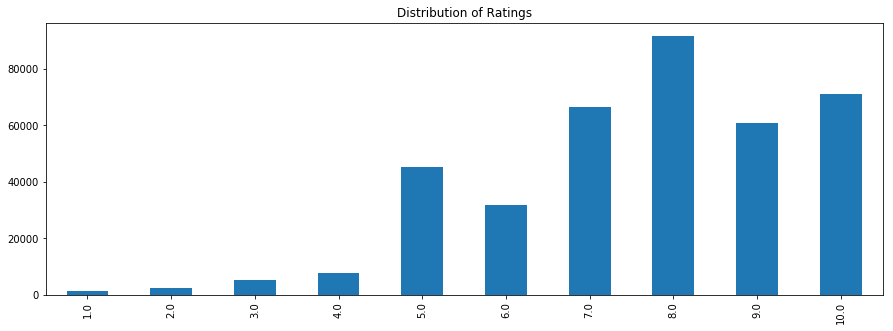

In [12]:
ax = results.plot.bar(
    title='Distribution of Ratings',
    figsize=(15,5)
)

## Build the recommender system<a name="build_recommender"/>

### Partition the tables
Subsequent actions are more efficient if the ratings table is partitioned once by the item
and a second table is partitioned by the user.

If you do not perform this step now, then many of the subsequent actions will automatically
make a copy of the data and group by the item or the user.  If that is done once, it is
convenient.  However the notebook shows several actions so the data transfer and reorganization 
is done once so that subsequent actions are more memory and CPU efficient.

In [13]:
ratings_by_item = s.CASTable('ratings_by_item', replace=True)
result = ratings.groupby('ISBN').partition(casout=ratings_by_item)
    
ratings_by_user = s.CASTable('ratings_by_user', replace=True)
result = ratings.groupby('User_ID').partition(casout=ratings_by_user)

Now that we have two instances of the ratings table, partitioned by different variables,
we can drop the original ratings table.

In [14]:
ratings.table.droptable()

NOTE: Cloud Analytic Services dropped table RATINGS from caslib CASUSERHDFS(mimcki).


+ Elapsed: 0.0572s, user: 0.262s, sys: 0.751s, mem: 44.4mb

In [15]:
book_recommend = s.CASTable('bookRecommend', replace=True)

results = s.recommend.recomCreate(
    system=book_recommend,
    user='User_ID',
    item='ISBN',
    rate='Rating')

### Determine average ratings by user and item

For the average ratings by user, specify the ratings table that is partitioned by user. If the table is not already partitioned by user, then the action will temporarily group the data for you.  However, it slows the action. 

In [16]:
avg_user = s.CASTable('avg_user', replace=True)

results = ratings_by_user.recommend.recomRateinfo(
    label='avg_user_model',
    system=book_recommend,
    id='User_ID',
    sparseid='ISBN',
    sparseval='rating',
    casout=avg_user)

In [17]:
result = avg_user.head()
result

,User_ID,_Stat_,_NRatings_
0,951.0,8.0,1.0
1,17871.0,8.5,2.0
2,38899.0,7.5,4.0
3,58389.0,8.0,17.0
4,79712.0,4.0,1.0


You can view the ratings to confirm that the average is shown.  If the first user
has a single rating, you can rerun the preceding cell with `avg_user.query("_nrating_ = 2").head()` or a related query.

In [18]:
firstUser = result.loc[0,'User_ID']
count     = result.loc[0,'_NRatings_']
ratings_by_user[ratings_by_user.user_id == firstUser].head(count)

,User_ID,ISBN,Rating
0,951.0,0375704043,8.0


Create an average ratings by item table.

In [19]:
avg_item = s.CASTable('avg_item', replace=True)

results = ratings_by_item.recommend.recomRateinfo(
    label='avg_item_model',
    system=book_recommend,
    id='isbn',
    sparseid='user_id',
    sparseval='rating',
    casOut=avg_item)

In [20]:
avg_item.head()

,ISBN,_Stat_,_NRatings_
0,0000913154,8.0,1.0
1,0061320935,6.0,1.0
2,0140154116,7.0,1.0
3,0192815687,8.0,2.0
4,0312444567,9.0,1.0


### Explore item ratings and user ratings
The tables that are created with the `recomrateinfo` action can be
used for simple data exploration.

### Discerning reviewers

In [21]:
avg_user.query('_nratings_ > 3').sort_values('_stat_').head(10)

,User_ID,_Stat_,_NRatings_
0,195653.0,1.000000,5.0
1,241992.0,2.000000,8.0
2,95511.0,3.000000,8.0
3,256618.0,3.000000,4.0
4,253036.0,3.000000,4.0
5,105535.0,3.333333,9.0
6,185679.0,3.400000,5.0
7,227771.0,3.437500,16.0
8,37034.0,3.500000,6.0
9,274837.0,3.500000,4.0


### Generous reviewers

In [22]:
avg_user.sort_values(['_stat_', '_nratings_'], ascending=False).head(10)

,User_ID,_Stat_,_NRatings_
0,182086.0,10.0,165.0
1,175003.0,10.0,32.0
2,167455.0,10.0,27.0
3,173835.0,10.0,26.0
4,52521.0,10.0,25.0
5,141203.0,10.0,23.0
6,187425.0,10.0,21.0
7,12272.0,10.0,21.0
8,69775.0,10.0,21.0
9,78469.0,10.0,17.0


### Ten most frequently reviewed books

In [23]:
s.fedSql.execDirect(query='''
  select t1.isbn, t1._stat_ as "Average Rating",
    t1._nratings_ as "Number of Ratings",
    t2.author, t2.title from
    avg_item as t1 join books as t2
    on (t1.isbn = t2.isbn) order by 3 desc limit 10
''')

,ISBN,Average Rating,Number of Ratings,Author,Title
0,0316666343,8.185290,707.0,Alice Sebold,The Lovely Bones: A Novel
1,0971880107,4.390706,581.0,Rich Shapero,Wild Animus
2,0385504209,8.435318,487.0,Dan Brown,The Da Vinci Code
3,0312195516,8.182768,383.0,Anita Diamant,The Red Tent (Bestselling Backlist)
4,0060928336,7.887500,320.0,Rebecca Wells,Divine Secrets of the Ya-Ya Sisterhood: A Novel
5,059035342X,8.939297,313.0,J. K. Rowling,Harry Potter and the Sorcerer's Stone (Harry P...
6,0142001740,8.452769,307.0,Sue Monk Kidd,The Secret Life of Bees
7,0446672211,8.142373,295.0,Billie Letts,Where the Heart Is (Oprah's Book Club (Paperba...
8,044023722X,7.338078,281.0,John Grisham,A Painted House
9,0452282152,7.982014,278.0,Tracy Chevalier,Girl with a Pearl Earring


### Frequently reviewed books with low ratings

In [24]:
result = avg_item.query('_nratings_ > 10').sort_values('_stat_').head(10)
result

,ISBN,_Stat_,_NRatings_
0,0971880107,4.390706,581.0
1,0679463321,5.066667,15.0
2,0349111863,5.076923,13.0
3,0142000981,5.133333,15.0
4,0871138190,5.166667,12.0
5,3518368001,5.181818,11.0
6,0312288115,5.250000,20.0
7,0802132952,5.285714,21.0
8,0802139868,5.333333,15.0
9,0425182908,5.338028,71.0


In [25]:
#Store the ISBN for the first row.
first_isbn = result.loc[0, 'ISBN']

result = ratings_by_item['rating'].query("isbn eq '%s'" % first_isbn).dataPreprocess.histogram() 

display(Markdown('#### Ratings Distribution for ISBN %s' % first_isbn))
display(result.BinDetails.loc[:, ['BinLowerBnd', 'NInBin', 'Percent']])

#### Ratings Distribution for ISBN 0971880107

,BinLowerBnd,NInBin,Percent
0,1.0,74,12.736661
1,2.0,82,14.113597
2,3.0,87,14.974182
3,4.0,58,9.982788
4,5.0,88,15.146299
5,6.0,66,11.359725
6,7.0,60,10.327022
7,8.0,40,6.884682
8,9.0,16,2.753873
9,10.0,10,1.721170


## Build a matrix factorization model<a name="build_matrixfactorization"/>
First, create a hold-out group.  From a random selection of 20% of users, hold out 1 rating.

After that, create the model.

In [26]:
holdout_users = s.CASTable('holdout_users', replace=True)

ratings_by_user.recommend.recomSample(
    system=book_recommend,
    label='holdout_users',
    withhold=.2, 
    hold=1,
    seed=1234,
    id='user_id',
    sparseid='isbn',
    casout=holdout_users
    )

,casLib,Name,Rows,Columns,casTable
0,CASUSERHDFS(mimcki),holdout_users,12403,2,"CASTable('holdout_users', caslib='CASUSERHDFS(..."


In [27]:
holdout_users.head(10)

,User_ID,ISBN
0,58389.0,1569875103
1,149562.0,0156126303
2,172186.0,0060628626
3,39514.0,0738846740
4,112570.0,0446310786
5,205980.0,0590435272
6,22809.0,0316779237
7,127893.0,0440222656
8,152515.0,0805205306
9,128843.0,0385499248


In [28]:
als_u = s.CASTable('als_u', replace=True)
als_i = s.CASTable('als_i', replace=True)

result = s.recommend.recomAls(
    system=book_recommend,
    tableu=ratings_by_user,
    tablei=ratings_by_item,
    label='als1',
    casoutu=als_u,
    casouti=als_i,
    rateinfo=avg_user,
    maxiter=20,
    hold=holdout_users,
    seed=1234,
    details=True,
    k=20,
    stagnation=10,
    threshold=.1
    )

result.ModelInfo.set_index('Descr')

,Value
Descr,
Model Label,als1
Number of Used Ratings,371193
Root Mean Squared Error (RMSE),0.2778073207
Mean Absolute Error (MAE),0.1534288461
Number of Ratings in Holdout Sample,12403
Root Mean Squared Error (RMSE) for Holdout Sample,1.3994474601
Mean Absolute Error (MAE) for Holdout Sample,1.0431048346


,Objective,Change,RMSE,MAE,RMSEHold,MAEHold
Iteration,,,,,,
0.0,308269.384217,NaN,0.636991,0.350190,1.439029,1.070502
1.0,221229.304210,-87040.080007,0.421535,0.225503,1.422682,1.059649
2.0,200539.480746,-20689.823465,0.359439,0.192990,1.415819,1.055047
3.0,191015.150613,-9524.330132,0.326705,0.176820,1.411208,1.051668
4.0,185949.110170,-5066.040443,0.308167,0.167858,1.407542,1.049101
5.0,182935.189625,-3013.920546,0.296827,0.162431,1.404814,1.047213
6.0,180974.306264,-1960.883361,0.289418,0.158915,1.402840,1.045816
7.0,179606.218714,-1368.087550,0.284303,0.156496,1.401393,1.044635
8.0,178598.232981,-1007.985732,0.280600,0.154748,1.400298,1.043770


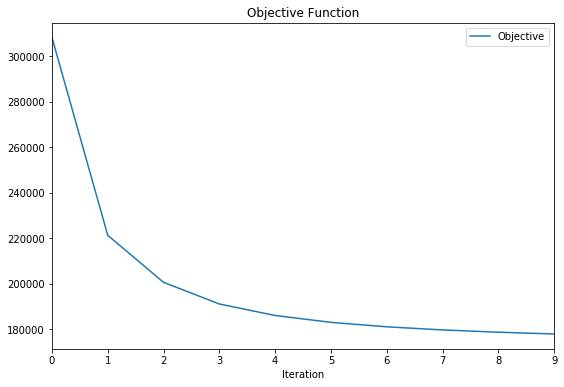

In [29]:
ax = result.IterHistory.plot(
    x='Iteration', y='Objective',
    title='Objective Function',
    figsize=(9,6)
)

result.IterHistory.set_index('Iteration')

### Make recommendations for one user

In [30]:
users= '104437'

recommendations = s.CASTable('recommendations', replace=True)

s.recommend.recomMfScore(
    system=book_recommend,
    label='als1',
    userlist=users,
    n=5,
    casout=recommendations
)

,casLib,Name,Rows,Columns,casTable
0,CASUSERHDFS(mimcki),recommendations,5,4,"CASTable('recommendations', caslib='CASUSERHDF..."


In [31]:
s.fedSql.execDirect(query='''
  select t1.*, t2.author, t2.title, 
  t3._stat_ as "Average Rating", t3._nratings_ as "Number of Ratings"
  from recommendations as t1
  left outer join books as t2 on (t1.isbn = t2.isbn)
  left outer join avg_item as t3 on (t1.isbn = t3.isbn)
  order by user_id, _rank_
''')

,User_ID,ISBN,_Rank_,_Rating_,Author,Title,Average Rating,Number of Ratings
0,104437.0,0060191457,1.0,11.636178,Gary Indiana,Three Month Fever: The Andrew Cunanan Story,1.000000,1.0
1,104437.0,0877732248,2.0,11.371851,LARRY DOSSEY,SPACE TIME MEDICINE,10.000000,1.0
2,104437.0,037541620X,3.0,11.302354,Anne Rice,The Anne Rice Collection: Mayfair Witches : La...,3.666667,3.0
3,104437.0,0595127924,4.0,11.288880,Benjamin David,So Is This Wilderness and Other Stories,1.000000,1.0
4,104437.0,0310916739,5.0,11.257740,Larry Richards,Bib Niv Teen Student,1.000000,1.0


### Make recommendations for hold-out users

In [32]:
recommend_heldout = s.CASTable('recommend_heldout', replace=True)

s.recommend.recomMfScore(
    system=book_recommend,
    label='als1',
    usertable=holdout_users,
    n=5,
    casout=recommend_heldout
)

,casLib,Name,Rows,Columns,casTable
0,CASUSERHDFS(mimcki),recommend_heldout,62015,4,"CASTable('recommend_heldout', caslib='CASUSERH..."


In [33]:
result = s.fedsql.execdirect(query='''
  select t1.*, t2.author, t2.title, 
  t3._stat_ as "Average Rating", t3._nratings_ as "Number of Ratings"
  from recommend_heldout as t1
  left outer join books as t2 on (t1.isbn = t2.isbn)
  left outer join avg_item as t3 on (t1.isbn = t3.isbn)
  order by user_id, _rank_
''')

# There are many rows in the results.  Print results for the first three users only.
three = result['Result Set'].loc[[0,5,10],:'User_ID'].values
for user in np.nditer(three):
    display(Markdown('#### Recommendations for user %s ' % user))
    display(result['Result Set'].query('User_ID == %s' % user))

#### Recommendations for user 8.0 

,User_ID,ISBN,_Rank_,_Rating_,Author,Title,Average Rating,Number of Ratings
0,8.0,067165747X,1.0,7.847256,Sonni Cooper,BLACK FIRE STAR TREK 8 (Star Trek (Numbered Pa...,2.000000,1.0
1,8.0,0880296879,2.0,7.588775,Jay Carter,Nasty People,2.000000,1.0
2,8.0,0373225830,3.0,7.345195,Simon Webb,"Safe By His Side (Secret Identity) (Intrigue, ...",1.000000,1.0
3,8.0,0702227579,4.0,7.302083,Hugh Lunn,Spies Like Us (Uqp Paperbacks Memoir),1.000000,1.0
4,8.0,0812968344,5.0,7.288302,Joyce Carol Oates,A Garden of Earthly Delights (Modern Library 2...,5.333333,3.0


#### Recommendations for user 14.0 

,User_ID,ISBN,_Rank_,_Rating_,Author,Title,Average Rating,Number of Ratings
5,14.0,0345438655,1.0,6.446891,Peter Straub,Julia,2.000000,1.0
6,14.0,039921268X,2.0,6.442082,Anne-Marie Chapouton,Ben Finds a Friend,4.333333,3.0
7,14.0,0821774719,3.0,6.379757,Elizabeth Doyle,Beyond Paradise (Zebra Historical Romance),1.000000,1.0
8,14.0,0807843490,4.0,6.379757,Janice A. Radway,"Reading the Romance: Women, Patriarchy, and Po...",1.000000,1.0
9,14.0,0449205118,5.0,6.369464,Victoria Holt,The Time of the Hunter's Moon,1.000000,1.0


#### Recommendations for user 56.0 

,User_ID,ISBN,_Rank_,_Rating_,Author,Title,Average Rating,Number of Ratings
10,56.0,0375812032,1.0,9.871000,CATHY YOUNG,One Hot Second : Stories About Desire,4.000000,1.0
11,56.0,0712625976,2.0,9.724332,Evelyn Hart,Mountains of the Sun,2.000000,1.0
12,56.0,0760708142,3.0,9.575278,U S Air Force,Roswell Report Case Closed,3.000000,1.0
13,56.0,014025238X,4.0,9.435528,Diane Schoemperlen,In the Language of Love: A Novel in 100 Chapters,6.333333,3.0
14,56.0,1570960127,5.0,9.408507,Elaine Barbieri,More Precious Than Gold,3.000000,1.0


## Build a KNN model<a name="build_knn"/>

### Calculate the similarity between users

In [34]:
similar_users = s.CASTable("similar_users", replace=True)

ratings_by_user.recommend.recomSim(
    label="similar_users",
    system=book_recommend,
    id="user_id",
    sparseId="isbn",
    sparseVal="rating",
    measure="cos",
    casout=similar_users,
    threshold=.2)

,casLib,Name,Rows,Columns,casTable
0,CASUSERHDFS(mimcki),similar_users,978001,3,"CASTable('similar_users', caslib='CASUSERHDFS(..."


### View the similarity for one pair of users
In this case, these two users read three of the same books.  They rated the three
at 7 and above.

In [35]:
result = similar_users.query("user_id_1 = 104437 and user_id_2 = 199981").head(1)
display(result)

def one_users_ratings(user_id):
    result = s.fedSql.execDirect(query='''
    select t1.*,
    t2.author, t2.title from ratings_by_user as t1
    left outer join books as t2 on (t1.isbn = t2.isbn)
    where t1.user_id = {}
    order by author, isbn;
    '''.format(user_id))
    display(Markdown('#### Ratings by user %s' % user_id))
    display(result)
    
one_users_ratings(104437)
one_users_ratings(199981)

,User_ID_1,User_ID_2,_Sim_
0,104437.0,199981.0,0.579126


#### Ratings by user 104437

,User_ID,ISBN,Rating,Author,Title
0,104437.0,0440212561,10.0,DIANA GABALDON,Outlander
1,104437.0,0440215625,7.0,DIANA GABALDON,Dragonfly in Amber
2,104437.0,0440217563,10.0,DIANA GABALDON,Voyager
3,104437.0,0553250426,7.0,Jean M. Auel,The Clan of the Cave Bear (Earth's Children (P...
4,104437.0,0671534742,7.0,V.C. Andrews,Music in the Night (Logan)
5,104437.0,0671729497,5.0,V.C. Andrews,Web of Dreams (Casteel)


#### Ratings by user 199981

,User_ID,ISBN,Rating,Author,Title
0,199981.0,0440212561,8.0,DIANA GABALDON,Outlander
1,199981.0,0440215625,10.0,DIANA GABALDON,Dragonfly in Amber
2,199981.0,0440217563,8.0,DIANA GABALDON,Voyager
3,199981.0,0385499825,7.0,Haven Kimmel,Girl Named Zippy: Growing Up Small in Moorelan...
4,199981.0,0671001795,7.0,Janet Evanovich,Two for the Dough
5,199981.0,0452280362,7.0,Linda Bruckheimer,Dreaming Southern
6,199981.0,0380730448,7.0,Sue Townsend,The Adrian Mole Diaries : The Secret Diary of ...


### Calculate KNN based on user's similar ratings

In [36]:
ratings_by_item.recommend.recomKnnTrain(
  label='knn1',
  system=book_recommend,
  similarity=similar_users,
  k=20,
  hold=holdout_users,
  rateinfo=avg_user,
  user=True # need to tell if similarity is for the user or the item
)


,Descr,Value
0,Model Label,knn1
1,Number of Used Ratings,94581
2,Root Mean Squared Error (RMSE),1.1979361055
3,Mean Absolute Error (MAE),0.8766571274
4,Number of Ratings in Holdout Sample,6186
5,Root Mean Squared Error (RMSE) for Holdout Sample,1.2934692262
6,Mean Absolute Error (MAE) for Holdout Sample,1.0043781166


In [37]:
users = ['104437']

knn_recommended = s.CASTable("knn_recommended", replace=True)

s.recommend.recomKnnScore(
  system="bookRecommend",
  label="knn1",
  userList=users,
  n=10,
  casout=knn_recommended
)

s.fedSql.execDirect(
    query='''
     select t1.*, t2.author, t2.title,
      t3._stat_ as "Average Rating", t3._nratings_ as "Number of Ratings"
      from knn_recommended as t1
      left outer join books as t2 on (t1.isbn = t2.isbn)
      left outer join avg_item as t3 on (t1.isbn = t3.isbn)
      order by user_id, _rank_;
    ''')


,User_ID,ISBN,_Rank_,_Rating_,Author,Title,Average Rating,Number of Ratings
0,104437.0,0553562738,1.0,10.963542,Connie Willis,Doomsday Book,8.714286,28.0
1,104437.0,0812551478,2.0,10.963542,Terry Goodkind,"Blood of the Fold (Sword of Truth, Book 3)",8.450000,20.0
2,104437.0,0812551494,3.0,10.963542,Terry Goodkind,"Soul of the Fire (Sword of Truth, Book 5)",7.714286,14.0
3,104437.0,0553573403,4.0,10.963542,George R.R. Martin,"A Game of Thrones (A Song of Ice and Fire, Boo...",8.500000,44.0
4,104437.0,0812548094,5.0,10.963542,Terry Goodkind,"Stone of Tears (Sword of Truth, Book 2)",7.909091,22.0
5,104437.0,0553579908,6.0,10.963542,George R. R. Martin,"A Clash of Kings (A Song of Fire and Ice, Book 2)",8.526316,19.0
6,104437.0,088038672X,7.0,10.963542,R.A. Salvatore,Streams of Silver (Forgotten Realms: The Icewi...,8.600000,5.0
7,104437.0,0679452869,8.0,10.963542,Evelyn McFarlane,If 2: 500 New Questions for the Game of Life,8.333333,3.0
8,104437.0,0786915749,9.0,10.963542,Margaret Weis,Dragons of Autumn Twilight (Dragonlance: Drago...,8.285714,21.0
9,104437.0,0786863900,10.0,10.963542,Cameron West,First Person Plural : My Life As a Multiple,8.000000,8.0


## Combine search with recommendations<a name="build_searchindex"/>

### Search can be included with recommendations
First, build the search index. 
* The recomSearchIndex action generates a global-scope table that is named the same as the label parameter.
* The generated index table is always appended when recomSearchIndex is run again with the same label. This can generate duplicate documents in the index table.
* To avoid duplicates, the table.dropTable action is run first.  The quiet=True parameter is used to ignore whether the table exists or not.

Afterward, run search queries for terms.

In [38]:
book_search = s.CASTable("book_search", replace=True)
book_search.table.droptable(quiet=True)

books.recommend.recomSearchIndex(
  system=book_recommend,
  label='book_search',
  id='isbn')

NOTE:  Will update the schema with the format from the data table.
NOTE:  The index schema will be updated.


[errorCode]

 0

[threads]

 {'fail_thds': 0, 'success_thds': 2268, 'total_thds': 2268}

[documents]

 {'append_docs': 271375, 'invalid_docs': 0, 'total_docs': 271375}

+ Elapsed: 2.93s, user: 69.6s, sys: 44.2s, mem: 47.5mb

In [39]:
yoga_query = 'yoga fitness'

query_filter = s.CASTable("query_filter", replace=True)

result = book_search.recommend.recomSearchQuery(
  system=book_recommend,
  label='book_search',
  casout=query_filter,
  query=yoga_query,
  n=100)

NOTE:  No fields object is detected in the output object, so all fields were returned.


In [40]:
query_filter.columnInfo()

,Column,ID,Type,RawLength,FormattedLength,Format,NFL,NFD
0,_id_,1,varchar,21,21,$,0,0
1,_relevance_,2,double,8,12,BEST,0,0
2,ISBN,3,char,10,10,,0,0
3,Title,4,varchar,140,303,,0,0
4,Author,5,varchar,29,143,,0,0
5,Year_Of_Publication,6,double,8,12,,0,0
6,Publisher,7,varchar,42,151,,0,0


In [41]:
yoga_reader = '99955'

filtered_results = s.CASTable('filtered_results', replace=True)

filtered_results = s.recommend.recomMfScore(
    system=book_recommend,
    label='als1',
    filter=query_filter,
    userlist=yoga_reader,
    n=5,
    casout=filtered_results
)

In [42]:
s.fedSql.execDirect(query='''
     select t1.*, t2.author, t2.title,
      t3._stat_ as "Average Rating", t3._nratings_ as "Number of Ratings"
      from filtered_results as t1
      left outer join books as t2 on (t1.isbn = t2.isbn)
      left outer join avg_item as t3 on (t1.isbn = t3.isbn)
      order by user_id, _rank_;
    ''')

,User_ID,ISBN,_Rank_,_Rating_,Author,Title,Average Rating,Number of Ratings
0,99955.0,0525947590,1.0,8.527714,Joe Decker,The World's Fittest You: Four Weeks to Total F...,5.5,2.0
1,99955.0,0375422145,2.0,7.514956,Geoff Dyer,Yoga for People Who Can't Be Bothered to Do It,6.0,1.0
2,99955.0,0395271622,3.0,7.494413,Covert Bailey,Fit Or Fat New Way to Health and Fitness,6.5,2.0
3,99955.0,0553277480,4.0,7.307167,RICHARD HITTLEMAN,Richard Hittleman's Yoga : 28 Day Exercise Plan,8.5,2.0
4,99955.0,1401900259,5.0,7.212376,Cyndi Lee,Om Yoga Flash Cards (Om Yoga),5.0,1.0


In [43]:
#s.close()

<a name="data_attribution"></a>
Data were used with permission from Dr. Cai-Nicolas Ziegler.  The following publication provides information about the dataset:

  [Improving Recommendation Lists Through Topic Diversification](http://www2.informatik.uni-freiburg.de/~dbis/Publications/05/WWW05.html)
  Cai-Nicolas Ziegler, Sean M. McNee, Joseph A. Konstan, Georg Lausen; *Proceedings of 
  the 14th International World Wide Web Conference (WWW '05)*, May 10-14, 2005, Chiba, Japan.
  To appear.